## Question 3 - Bootstrapping
#### The bootstrap method is a resampling technique used to estimate statistics on a population by sampling a dataset with replacement. It is used in applied machine learning to estimate the skill of machine learning models when making predictions on data not included in the training data. In this question, we are required to implement bootstrapping on the knn regressor function appplied from question 1 of the assignment and train and test it on the respective datasets.
We first begin with reading the data and using the knn function used earlier.

In [1]:
# KNN function (distance should be one of euclidean, maximum, manhattan, canberra, binary or minkowski)
knn <- function(train.data, train.label, test.data, K=3, distance = 'euclidean'){
    ## count number of train samples
    train.len <- nrow(train.data)
    
    ## count number of test samples
    test.len <- nrow(test.data)
    
    ## calculate distances between samples
    dist <- as.matrix(dist(rbind(test.data, train.data), method= distance))[1:test.len, (test.len+1):(test.len+train.len)]
    
    ## for each test sample...
    for (i in 1:test.len){
        ### ...find its K nearest neighbours from training sampels...
        nn <- as.data.frame(sort(dist[i,], index.return = TRUE))[1:K,2]
        
        ###... and calculate the predicted labels according to the majority vote
        test.label[i]<- (mean(train.label[nn]))
    }
    
    ## return the class labels as output
    return (test.label)
}

In [2]:
data<-read.csv('Task1B_train.csv')
train.data = data[,1:4]
train.label = data[,5]

In [3]:
data_test<-read.csv('Task1B_test.csv')
test.data = data[,1:4]
test.label = data[,5]

In [4]:
# load libraries:
library(reshape2)
library(ggplot2)

# Load data:
library(datasets)

Warning message:
"package 'reshape2' was built under R version 3.6.1"Warning message:
"package 'ggplot2' was built under R version 3.6.1"

We now define the function implement the bootstrapping. The function takes 3 parameters, which are original size i.e. the size of the entire dataset, sample size i.e. the size of the sample we wish to generate and times which tells us how many times we want to run the function. The function below does the following,
- initialize a matrix with dimensions of time x sample size
- sample the dataset with replacement and save it to the matrix
- return the matrix

In [5]:
# define a function that generates sample indixes based on bootstrap technique
boot <- function (original.size=100, sample.size=original.size, times=100){
    indx <- matrix(nrow=times, ncol=sample.size)
    for (t in 1:times){
        indx[t, ] <- sample(x=original.size, size=sample.size, replace = TRUE)
    }
    return(indx)
}

In [6]:
boot(nrow(train.data), 25, 10)

462,519,113,202,754,803,826,507,132,216,...,343,683,755,564,557,604,771,909,42,513
427,249,273,347,430,603,231,27,45,386,...,643,70,629,245,461,552,848,568,870,397
713,559,910,308,776,479,752,19,726,841,...,847,157,112,630,722,777,130,412,146,816
224,907,145,902,151,689,560,64,59,761,...,876,578,232,417,666,766,365,550,565,629
401,687,227,383,308,298,96,538,362,364,...,672,588,325,124,657,802,862,253,764,856
686,378,82,301,762,566,481,6,188,344,...,610,304,886,312,698,231,21,479,484,187
754,120,214,902,905,706,111,695,377,578,...,3,343,720,457,750,545,753,767,563,857
399,750,925,194,165,383,715,596,883,452,...,734,42,497,146,280,125,320,929,471,800
27,643,651,712,812,859,443,55,477,340,...,51,464,600,90,917,478,4,283,430,59
309,559,601,436,647,565,81,21,62,652,...,408,279,741,111,547,106,764,365,762,244


Below, we implement knn along with bootstrapping. The function does the following,
- Initialize k, number of datasets(L) and the size of dataset(N).
- For each k and L, perform bootstrapping and run knn on the data and record the errors in the miss dataframe

In [7]:
# fix the parameters (50,40,50)
K <- 20           # Maximum K for KNN 
L <- 100        # number of datasets
N <- 25         # size of datasets

# generate bootstrap indices:
boot.indx <- boot(nrow(train.data), N, L)

# a dataframe to track the number of missclassified samples in each case
miss <- data.frame('K'=1:K, 'L'=1:L, 'test'=rep(0,L*K))

# THIS MAY TAKE A FEW MINUTES TO COMPLETE
## for every k values:
for (k in 1: K){
    
    ### for every dataset sizes:
    for (l in 1:L){
        
        #### calculate iteration index i
        i <- (k-1)*L+l
        
        #### save sample indices that were selected by bootstrap
        indx <- boot.indx[l,]
        
        #### save the value of k and l
        miss[i,'K'] <- k
        miss[i,'L'] <- l
        
        #### calculate and record the train and test missclassification rates
        miss[i,'test'] <-  sqrt(sum((knn(train.data[indx, ], train.label[indx], test.data, K=k)  - test.label)**2)/nrow(test.data))
    } 
}

In [8]:
miss.m <- melt(miss, id=c('K', 'L')) # reshape for visualization
names(miss.m) <- c('K', 'L', 'type', 'RMSE')

The code below generates the plot for different values of K and RMSE reported for them.

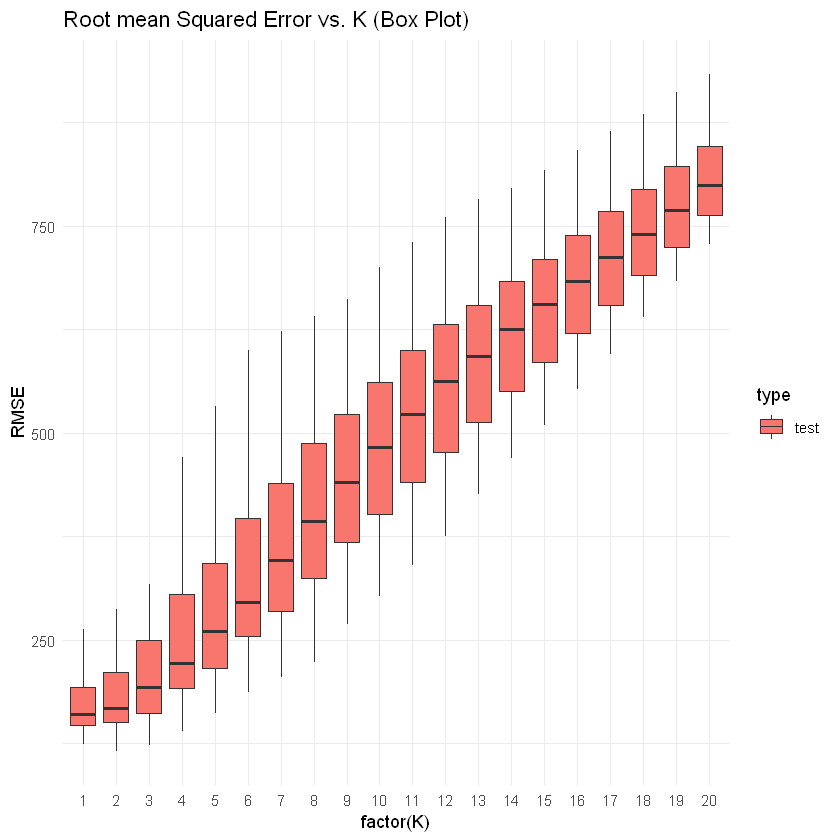

In [9]:
ggplot(data=miss.m[miss.m$type=='test',], aes(factor(K), RMSE,fill=type)) + geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + ggtitle('Root mean Squared Error vs. K (Box Plot)') + theme_minimal()
# ignore the warnings (because of ignoring outliers)
options(warn=-1)

From the plot, we can ascertain that as the value of K increases, the uncertainty and the test error increases as well. The uncertainty of the model increases a lot around k = 6 to k = 12 after which the model starts becoming less flexible and more complex which leads to more certainty however the test error is high these values of k. 

We now applying our bootstrap function k=10 , a size of 25 and for 10,20,....200 times. After which we create a boxplot with times on the x axis and RMSE on the y axis.

In [10]:
# fix the parameters 
K <- 10           # Maximum K for KNN 
N <- 25         # size of datasets

In [11]:
# generate bootstrap indices:
# a dataframe to track of the error
miss <- data.frame(L=character(), l=character(), error=double())

## for every L values:
for (L in  seq(10, 200, by=10)){    
    ### for every dataset sizes:
    boot.indx <- boot(nrow(train.data), N, L)
    # Iterate through each sample
    for (l in 1:L ){
        #### save sample indices that were selected by bootstrap
        indx <- boot.indx[l,]
        
        
        #### calculate and record the test error
        err <- sqrt(sum((knn(train.data[indx, ], train.label[indx], test.data, K=10)  -test.label)**2)/nrow(test.data))
        de <- list('L'=L, 'l'=l, 'Test'=err)
        miss<-rbind(miss,de, stringsAsFactors=FALSE)
    } 
}

In [13]:
miss.m <- melt(miss, id=c('l', 'L')) # reshape for visualization
names(miss.m) <- c('l', 'L', 'type', 'RMSE')

In [14]:
head(miss.m)

l,L,type,RMSE
1,10,Test,482.5056
2,10,Test,519.3741
3,10,Test,618.5676
4,10,Test,434.4137
5,10,Test,638.1434
6,10,Test,601.1468


Below we create the visualizations with times on the x axis and RMSE on the y axis.

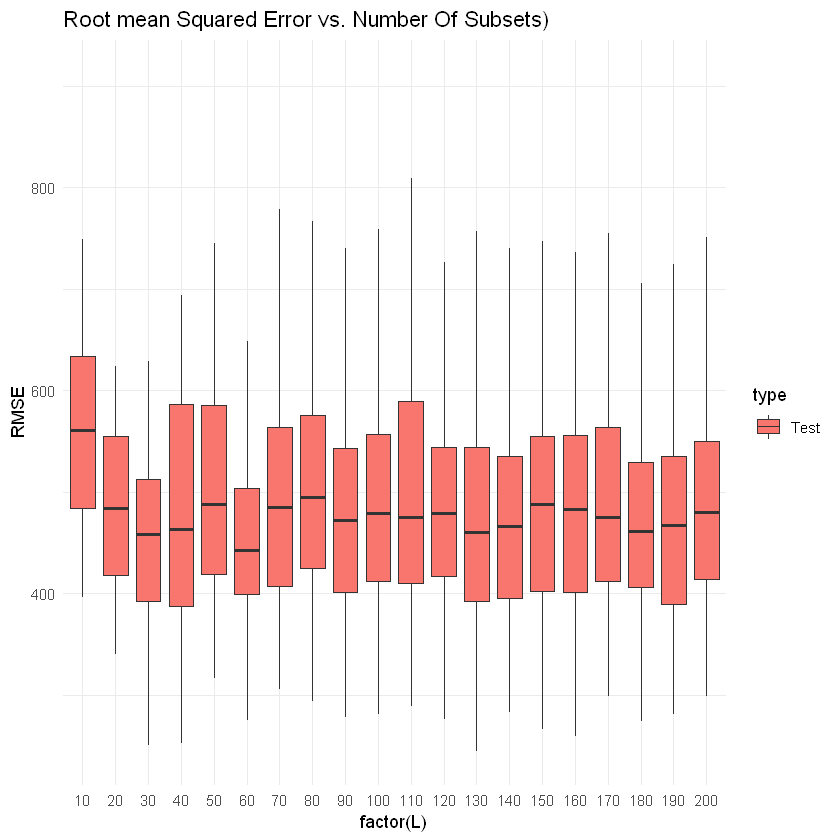

In [16]:
ggplot(data=miss.m[miss.m$type=='Test',], aes(factor(L), RMSE,fill=type)) + geom_boxplot(outlier.shape = NA)  + 
    scale_color_discrete(guide = guide_legend(title = NULL)) + 
    ggtitle('Root mean Squared Error vs. Number Of Subsets)') + theme_minimal()
# ignore the warnings (because of ignoring outliers)
options(warn=-1)

We can see from the above plot that as the number of subset increases, the RMSE and the uncertainty decreases initially till around 30 times after which there is no concrete trend as it increases/decreases quite randomly. The RMSE and uncertainty is least at 60 times after 130 times as well.